Text(0.5, 1.0, 'Autoregressive Process')

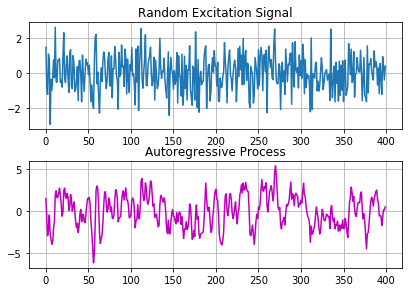

In [1]:
##Generating a second order autoregressive process
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

#Length of time series
N = 400
#Gaussian random numbers as an excitation signal
ex = np.random.randn(N)

#Second order AR Process
a = np.array([1.2,-0.4])

S = ex.copy()
for n in range(2,N):
    x = np.array([S[n-1],S[n-2]])
    S[n] = np.dot(x,a) + ex[n]
fig,ax = plt.subplots(nrows = 2,ncols=1,figsize=(6,4))
plt.tight_layout()

ax[0].plot(range(N),ex)
ax[0].grid(True)
ax[0].set_title("Random Excitation Signal")

ax[1].plot(range(N),S,color='m')
ax[1].grid(True)
ax[1].set_title("Autoregressive Process")


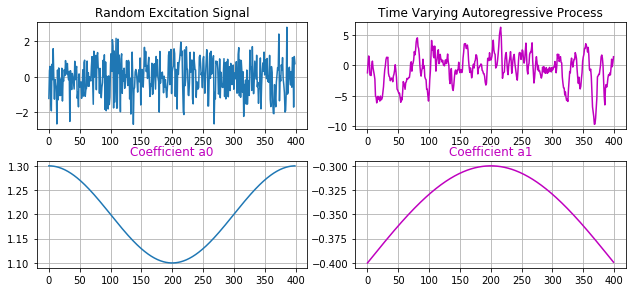

In [2]:
##Generating a Time-varying AR process
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
# Length of time series
#
N=400
# Gaussian random numbers as an excitation signal
#
ex = np.random.randn(N)
# Second order AR Process with coefficients slowly changing in time
a0 = np.array([1.2,-0.4])
A = np.zeros((N,2))
omega, alpha = N/2,0.1
for n in range(N):
    A[n,0] = a0[0] + alpha * np.cos(2*np.pi*n/N)
    A[n,1] = a0[1] + alpha * np.sin(np.pi*n/N)
S = ex.copy()
for n in range(2,N):
    x = np.array([S[n-1],S[n-2]])
    S[n] = np.dot(x,A[n,:])+ex[n]

fig,ax = plt.subplots(nrows=2,ncols=2,figsize=(9,4))
plt.tight_layout()

ax[1,0].plot(range(N),A[:,0])
ax[1,0].grid(True)
ax[1,0].set_title("Coefficient a0",color='m')

ax[1,1].plot(range(N),A[:,1],color='m')
ax[1,1].grid(True)
ax[1,1].set_title("Coefficient a1",color='m')
ax[0,0].plot(range(N), ex)
ax[0,0].grid(True)
ax[0,0].set_title("Random Excitation Signal")
ax[0,1].plot(range(N), S, color='m')
ax[0,1].grid(True)
ax[0,1].set_title("Time Varying Autoregressive Process")
plt.savefig("arChange.png")

1.046270141704884
[[0.01 0.  ]
 [0.   0.01]]
[ 1.2 -0.4]
[[ 1.06567797]
 [-0.31468587]]


Text(0.5, 1.0, 'R = 1.046,Q = 0.01000 I')

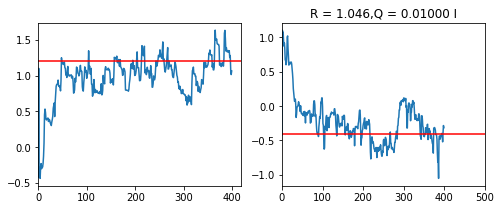

In [3]:
#Kalman Filter Estimates of second order AR parameters
# Time series data y
# th_n_n: estimate at time n using all data upto time n
# th_n_n1: estimate at time n using all data upto time n-1
#
# Initialize
#
x = np.zeros((2,1))
th_n1_n1 = np.random.randn(2,1)
P_n1_n1 = 0.001*np.eye(2)
# Noise variances -- hyperparameters (to be tuned)
# Set measurement noise as fraction of data variance (first few samples)
# Guess for process noise
#
R = 1*np.std(ex[0:10])
print(R)
beta = 0.01
Q = beta*np.eye(2)
print(Q)
# Space to store and plot
#
th_conv = np.zeros([2, N])
# First two estimates are initial guesses
#
th_conv[0,0] = th_n1_n1[0]
th_conv[0,1] = th_n1_n1[1]
th_conv[1,0] = th_n1_n1[0]
th_conv[1,1] = th_n1_n1[1]
y = S
# Kalman Iteration Loop (univariate observation, start from time step 2)
for n in range(2,N):
    #Input vector contains past values
    x[0] = y[n-1]
    x[1] = y[n-2]
    
    #Prediction of state and covariance
    th_n_n1 = th_n1_n1.copy()
    P_n_n1 = P_n1_n1 + Q
    
    yh = th_n_n1.T @ x
    en = y[n] - yh
    #ePlot[n] = en

    #Kalman gain(kn) and innovation variance
    den = x.T @ P_n_n1 @ x+R
    kn = P_n_n1 @ x / den

    #Posterior update
    th_n_n = th_n_n1 + kn * en
    P_n_n = (np.eye(2) - kn @ x.T) @ P_n_n1

    # Save
    th_conv[0,n] = th_n_n[0]
    th_conv[1,n] = th_n_n[1]

    #Remember for next step
    th_n1_n1 = th_n_n.copy()
    P_n1_n1 = P_n_n.copy()

print(a)
print(th_n_n)
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(8,3))
ax[0].plot(th_conv[0])
ax[0].set_xlim(0.500)
ax[0].axhline(y=a[0],color='r')

ax[1].plot(th_conv[1])
ax[1].set_xlim(0,500)
ax[1].axhline(y=a[1],color='r')
ax[1].set_title("R = %4.3f,Q = %6.5f I"%(R,beta))

Text(0.5, 1.0, 'Initial Particles')

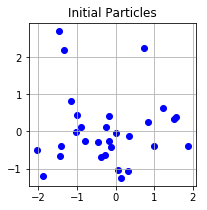

In [8]:
##Partile Filter Estimates of second order AR parameters
#A distribution of random particles in 2D
Ns = 30
#Initial particles
parts = np.random.randn(Ns,2)
fig,ax = plt.subplots(figsize=(3,3))
ax.scatter(parts[:,0],parts[:,1],color='b')
ax.grid(True)
ax.set_title("Initial Particles")

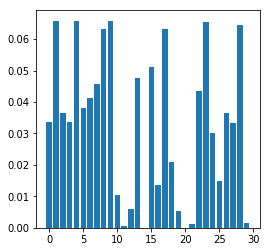

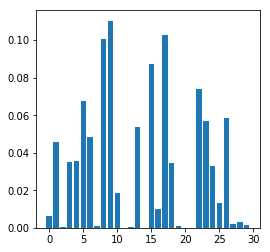

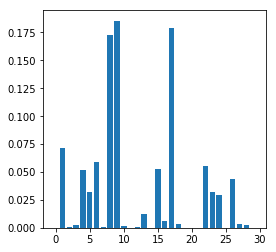

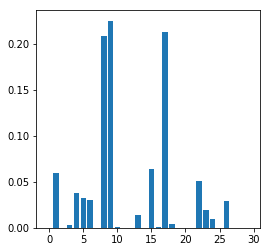

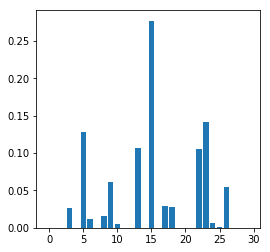

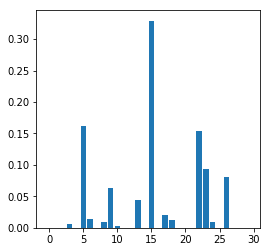

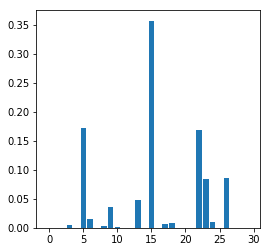

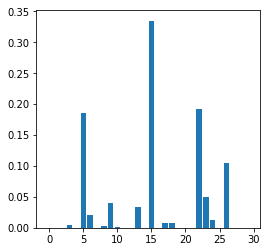

In [6]:
##Algorithm 1: Sequential Monte Carlo
#Likelihood from Gaussian noise
#Needs estimate true value and noise variance
def particle_likelihood(y0,yh,sig):
    lhood = (1/(2*np.pi*sig))*np.exp(-0.5*(y0-yh)**2)
    return lhood

#Process noise covariance is beta*I
beta = 0.01

#Observation noise variance
sig = np.std(ex)

#Initial input vector and particle weights
x = np.zeros((2,1))
pweights = np.ones((Ns,1))/Ns

#Go over the data
for n in range(2,10):
    x[0] = S[n-1]
    x[1] = S[n-2]
    
    #Sample particles from the prior
    #in the simplest case here, random perturbation
    for p in range(Ns):
        parts[p,:] = parts[p,:] + beta*np.random.randn(1,2)
        
    #Predictions and likelihoods
    sh = np.zeros((Ns,1))
    lhoods = sh.copy()
    for particle in range(Ns):
        th = parts[particle,:].T.copy()
        sh[particle] = x.T@th
        lhoods[particle] = particle_likelihood(S[n],sh[particle],sig)
    #multiply prior weights by likelihoods and normalize
    pweights = pweights * lhoods
    pweights = pweights / np.sum(pweights)
    #Observe how the weights change as you update
    fig,ax = plt.subplots(figsize=(4,4))
    ax.bar(np.arange(len(pweights)),pweights[:,0])
    

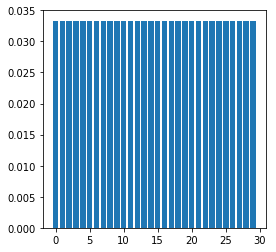

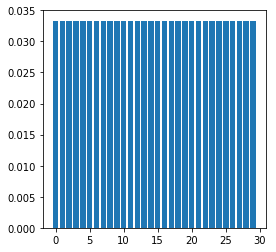

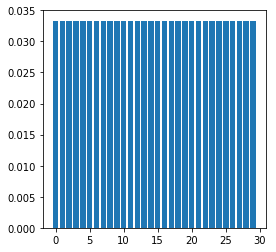

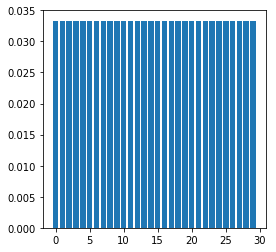

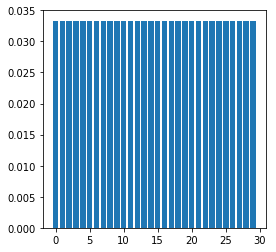

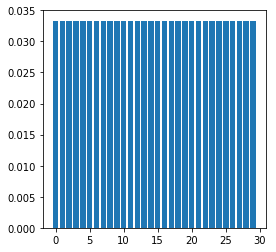

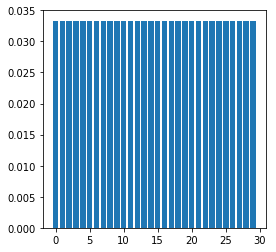

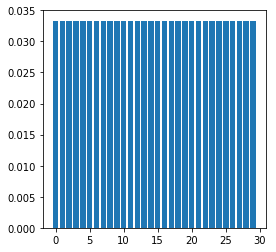

In [12]:
##Algorithm 2: Resampleing method
#Likelihood from Gaussian noise
#Needs estimate true value and noise variance
def particle_likelihood(y0,yh,sig):
    lhood = (1/(2*np.pi*sig))*np.exp(-0.5*(y0-yh)**2)
    return lhood
def resample(parts,weights):
    reparts = np.zeros((Ns,2))
    newweights = np.ones((Ns,1))/Ns
    c = np.zeros(Ns)
    for i in range(1,Ns):
        c[i] = c[i-1]+weights[i]
    u = np.zeros((Ns,1))
    u[0] = np.random.uniform(0,1/Ns)
    for j in range(1,Ns):
        u[j] = u[0]+(j-1)/Ns
        while (u[j] > c[i]) and (i !=( Ns-1)):
            i = i+1
        reparts[j] = parts[i]
        newweights[j] = 1/Ns
    return reparts,newweights
        
        
#Process noise covariance is beta*I
beta = 0.01

#Observation noise variance
sig = np.std(ex)

#Initial input vector and particle weights
x = np.zeros((2,1))
pweights = np.ones((Ns,1))/Ns

#Go over the data
for n in range(2,10):
    x[0] = S[n-1]
    x[1] = S[n-2]
    
    #Sample particles from the prior
    #in the simplest case here, random perturbation
    for p in range(Ns):
        parts[p,:] = parts[p,:] + beta*np.random.randn(1,2)
        
    #Predictions and likelihoods
    sh = np.zeros((Ns,1))
    lhoods = sh.copy()
    for particle in range(Ns):
        th = parts[particle,:].T.copy()
        sh[particle] = x.T@th
        lhoods[particle] = particle_likelihood(S[n],sh[particle],sig)
    #multiply prior weights by likelihoods and normalize
    pweights = pweights * lhoods
    pweights = pweights / np.sum(pweights)
    parts,pweights = resample(parts,pweights)
    #Observe how the weights change as you update
    fig,ax = plt.subplots(figsize=(4,4))
    ax.bar(np.arange(len(pweights)),pweights[:,0])
    

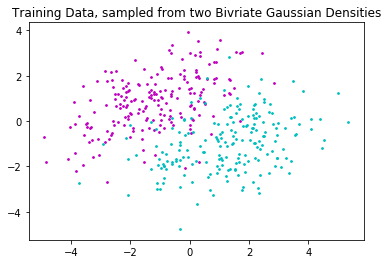

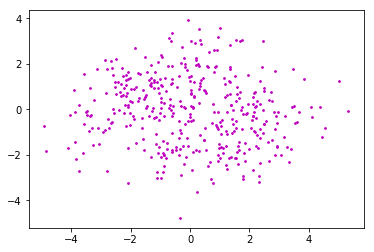

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
###Extended Kalman Filter for Logistic Regression
##Implementation

N = NumDataPerClass = 200
ex = np.random.randn(N)

m1 = [[-1,1]]
m2 = [[1,-1]]
C = [[2,1],[1,2]]

A = np.linalg.cholesky(C)

X1 = np.random.randn(NumDataPerClass,2)
Y1 = X1 @ A + m1

X2 = np.random.randn(NumDataPerClass,2)
Y2 = X2 @ A + m2
plt.figure(0)
plt.scatter(Y1[:,0],Y1[:,1],s =3,c='m')
plt.scatter(Y2[:,0],Y2[:,1],s =3,c='c')

plt.title('Training Data, sampled from two Bivriate Gaussian Densities')
plt.savefig('E:/Southampton University/Reinforcement Learning/Labs/Lab2/fig1.png')
y = np.concatenate((Y1,Y2)) #2. Concratenate data from 2 classes into one array

labelPos = np.ones(NumDataPerClass)
labelNeg = np.zeros(NumDataPerClass)
f = np.concatenate([labelPos, labelNeg])
# shuffle
ind = np.arange(len(y))
np.random.shuffle(ind)
data = y[ind]
f = f[ind]
plt.figure(1)
plt.scatter(data[:,0],data[:,1],s =3,c='m')
#plt.scatter(y[N:,0],y[N:,1],s =3,c='c')
#plt.title('Training Data, sampled from two Bivriate Gaussian Densities')

In [86]:
data.shape

(400, 2)

In [5]:
# 第二步 绘制决策边界
def plot_decision_boundary(y,theta,epoch):
    x_min, x_max = y[:, 0].min() - 1, y[:, 0].max() + 1
    y_min, y_max = y[:, 1].min() - 1, y[:, 1].max() + 1
    h = 0.01
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    d = np.c_[xx.ravel(), yy.ravel()].shape[0]
    #data= np.c_[xx.ravel(), yy.ravel()]
    #data = data.reshape(2,d)
    #print(theta.shape)
    Z = 1/(1+np.exp(-np.c_[xx.ravel(), yy.ravel()]@ theta))
    #Z = np.c_[xx.ravel(), yy.ravel() @ theta
    Z[Z<0.5] = 0
    Z[Z>=0.5] = 1    
    Z = Z.reshape(xx.shape)
    
    
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)  
    
    #plt.savefig('E:/Southampton University/Reinforcement Learning/Labs/Lab2/'+str(int(epoch))+'.jpg')


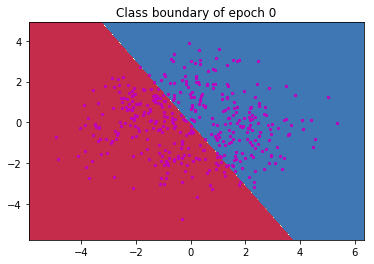

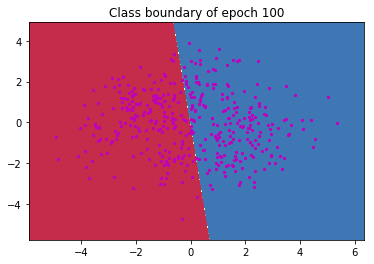

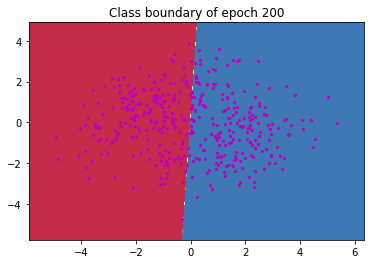

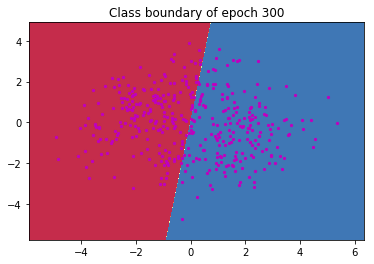

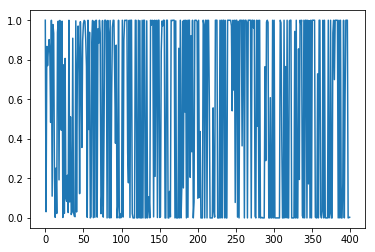

In [6]:
# Time series data y
# th_n_n: estimate at time n using all data upto time n
# th_n_n1: estimate at time n using all data upto time n-1
#
# Initialize
#
k = 1
X = data
y = f
w = np.random.random((k*2,1))
#print(th_n1_n1)
P = 0.01*np.eye(k*2)
# Noise variances -- hyperparameters (to be tuned)
# Set measurement noise as fraction of data variance (first few samples)
# Guess for process noise
#

R = 0.01*np.std(ex[0:10])
#print(R)
beta = 0.001
Q = beta*np.eye(k*2)
#print(Q)
# Space to store and plot
#
ePlot = np.ones(2*N)
# Kalman Iteration Loop (univariate observation, start from time step 2)
for n in range(k,len(X)):
    #Input vector contains past values
    x = np.array(X[n-k:n,:]).reshape(k*2,1)
    w = w.copy()
    P = P + Q
    yh = 1/(1+np.exp(-w.T@x))
    H = yh*(1-yh)*(-x)
    en = y[n] - yh
    ePlot[n] = abs(en)

    #Kalman gain(kn) and innovation variance
    den = H.T @ P @ H+R
    kn = P @ H / den
    #Posterior update
    w += kn * en
    P = P - kn @ H.T @ P
    if n % 100 == 1:
        plt.figure()
        plot_decision_boundary(X,w,n)
        plt.scatter(X[:, 0], X[:, 1],s =5,c='m')
        plt.title('Class boundary of epoch %d'%(n-1))

plt.figure()
plt.plot(ePlot)
plt.savefig('E:/Southampton University/Reinforcement Learning/Labs/Lab2/fig2.png')

In [12]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
raw_dataset = np.loadtxt('E:\\Southampton University\\Reinforcement Learning\\Labs\\Lab2\\regression\\regression\\Twitter\\Twitter.data',delimiter =',')
print(raw_dataset.shape)


(583250, 78)


In [67]:
###Online PCA
X = raw_dataset[0:20,:]
[n,d] = X.shape
print(X[0].shape)
l = 20
#e = np.random.uniform(0,1/15)
y = np.zeros((n,l))
U = np.zeros((d,l))
C = np.zeros((d,d))
wu = np.zeros((l,1))
theta = 2*np.linalg.norm(X,ord='fro')**2/l
print(theta)
for t in range(n):
    rt = X[t]-U@U.T*X[t]
    i = 0
    while np.linalg.norm(C+rt@rt.T) >= theta:
        value,vector = np.linalg.eig(C)
        evalue = max(value)
        evector = vector[np.where(value==evalue)]
        if i < l:
            wu[i] = evalue
            U[:,i] = evector
        else:
            index = np.where(wu==min(wu))
            wu[index[0][0]] = evalue
            U[:,index[0][0]] = evector
        C = C-evalue*evector.T@evector
        rt = X[t]-U@U.T*X[t]
        #print(C)
        print(np.linalg.norm(C+rt@rt.T))
        i+=1
    #for i in range(k/(e**3)):
        #if U[:,i] != np.zeros((U[:,i].shape)):
            #wu[i] = wu[i]
    C = C+rt@rt.T
    y[t] = X[t] @ U    
        
print(y.shape)        


(78,)
3923.450000000475
12655.294067440282
13029.207973929111
13407.414181044367
13805.400285489386
14183.890234660883
14555.70562771285
14896.322027532935
15241.16840988732
15581.144401861655
15912.050472097948
16236.794869247216
16552.941852845637
16857.12839791401
17129.569890997238
17420.848272746323

D:\Anaconda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
D:\Anaconda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:22: ComplexWarning: Casting complex values to real discards the imaginary part



17707.370718823462
17988.694250827168
18264.18283528048
18532.21389314365
18787.367386813083
19227.857668607765
20062.37979666692
20842.96340413656
21851.675125364276
22945.433405569933
23601.225137941758
24354.53462039456
25171.83238878094
26149.73604263221
26845.090099938272

D:\Anaconda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:25: ComplexWarning: Casting complex values to real discards the imaginary part
D:\Anaconda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:26: ComplexWarning: Casting complex values to real discards the imaginary part



27437.835976883653
27980.078022067166
28572.09402567379
29071.182875340684
29628.63221208948
30580.171795178467
30970.71432926601
31409.203019003926
31889.55981264335
32290.661521442045
32753.64012142673
33653.54728442653
33899.35448568823
34219.268024308774
34426.68444492467
34701.34110896659
35154.70949082814
35573.80790530027
35959.53410161826
36428.28895548532
36953.70710129974
37374.14594861543
37773.64693914998
38280.24334363913
38585.61696514415
38989.47853354399
39545.93166639939
39833.61875036063
40109.16766626984
40476.28833077844
40788.92475029812
40962.3327638669
41694.754900641594
42432.666195482874
43158.85422329838
43471.48262069794
43822.38529728139
44609.33776546297
45562.18938178472
46658.46953790193
46851.26852231572
47297.44469714028
47904.765465626755
48209.67621201225
48579.70532993931
48959.029739828016
49430.94296607091
49711.28229942715
49852.70559060663
49983.066349148896
50087.437350384316
50352.38223735694
50574.40103217392
50851.38603817474
51294.664961802

151791.1817328974
152313.0440022232
152884.31699671023
153233.0173187434
153635.45360823852
154226.3750628326
154612.04163370558
154787.31374903966
155199.1743477413
155659.16387178667
156005.68536912533
156343.17014779215
156700.76573615536
156808.02330309767
156804.21573406731
156819.014535343
156861.0466053129
156881.458107789
156927.29222517353
156963.03848182043
157051.95242236071
157117.60351177814
157201.84628240176
157272.6810735304
157319.78329635775
157421.3300079853
157494.93719245456
157602.2677778621
157762.91051093052
157914.2738875623
158067.6863553316
158232.53166025065
158397.2496430158
158590.4610313525
158700.34168006614
158826.10895025468
158911.70374982263
158883.88992888076
159008.83584206126
159250.16568427815
159445.1538662671
159598.8722136998
159734.72593556665
159982.4019846637
160248.75917502132
160509.58758421315
160750.2477657399
160869.3990224337
161226.59397641776
161504.6872648477
161827.72051089618
162203.54127789213
162642.6845424208
163094.4766707233

200716.93814213705
200913.5288127961
201162.3193165558
201389.0367696
201652.54771747402
201851.60181140708
202087.47358841915
202235.82366640243
202347.07135787417
202619.09420864342
202745.91363933415
202920.25403017973
203045.2543919667
203196.27776541433
203444.69792707378
203540.67761931414
203809.33360493585
203943.2518903153
204141.541359006
204238.57287335632
204322.4427134251
204445.33061601222
204589.1028567399
204801.6347360389
204896.92101570364
205105.13404253582
205180.20743697346
205349.07183374566
205583.86534869228
205874.90699812266
206159.69102933438
206191.65182007005
206417.20524453922
206535.68357880216
206781.39619928776
206866.42808801171
207099.9746834689
207326.1930383671
207319.0456997555
207526.44623702214
207607.5607445554
207716.88236899328
207735.36879011925
207814.0128327856
207941.93709185612
208070.75689325537
208124.27171770635
208212.1434802138
208358.2298942592
208458.25661983274
208645.82121607233
208792.91271331738
208862.1271013806
208939.7966154

KeyboardInterrupt: 

In [30]:
x,y = np.linalg.eig(C)
print(max(x))
print(y[np.where(x==max(x))].shape)

(3510.0000000060845+0j)
(1, 78)


In [54]:
print(min(wu))
print(wu[19],wu[0])
print(np.where(wu==wu[0]))
U[:,1].shape

[3027.36542385]
[3027.36542385] [3510.00000001]
(array([0], dtype=int64), array([0], dtype=int64))


(78,)

In [57]:
index[0][0]

19